Bias and Variance
================

[*Machine learning class*](https://sites.google.com/a/unal.edu.co/machine-learning-2013-2/) *support material, Universidad Nacional de Colombia, 2013*

The purpose of this notebook is to illustrate the bias-variance trade-off when learning regression models from data. We will use and example based on non-linear regression presented in Chapter 4 of [[Alpaydin10]](#biblio).

Training data generation
------------------------

First we will write a function to generate a random sample. The data generation model is the following:

$$r(x) = f(x) + \epsilon$$

with $\epsilon\sim\mathcal{N}(0,1)$

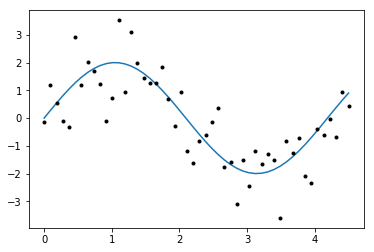

In [1]:
import numpy as np
import pylab as pl
%matplotlib inline
def f(size):
    '''
    Returns a sample with 'size' instances without noise.
    '''
    x = np.linspace(0, 4.5, size)
    y = 2 * np.sin(x * 1.5)
    return (x,y)

def sample(size):
    '''
    Returns a sample with 'size' instances.
    '''
    x = np.linspace(0, 4.5, size)
    y = 2 * np.sin(x * 1.5) + pl.randn(x.size)
    return (x,y)
    
pl.clf()
f_x, f_y = f(50)
pl.plot(f_x, f_y)
x, y = sample(50)
pl.plot(x, y, 'k.')

Model fitting
=============

We will use least square regression (LSR) to fit a polynomial to the data. Actually, we will use multivariate linear regression, over a dataset built in the following way:

For each sample $x_{i}$ we build a vector $(1 , x_{i} , x_{i}^{2} , \dots , x_{i}^{n})$  and we use LSR to fit a function $g:\mathbb{R}^{n+1}\rightarrow\mathbb{R}$ to the training data.

In [2]:
# This illustrates how vander function works:
x1 = np.array([1,2,3])
print (np.vander(x1, 4))

[[ 1  1  1  1]
 [ 8  4  2  1]
 [27  9  3  1]]


In [5]:
from sklearn.linear_model import LinearRegression
class PolynomialLinearRegression:
    def __init__(self, degree):
        self.degree = degree
        self.model = LinearRegression()
        
    def fit(self, X,y):
        self.model.fit(np.vander(X, self.degree + 1), y)
        
    def predict(self, X):
        return self.model.predict(np.vander(X, self.degree + 1))

    def score(self, X, y):
        # rmse
        return np.sqrt(np.mean((y-self.predict(X))**2))

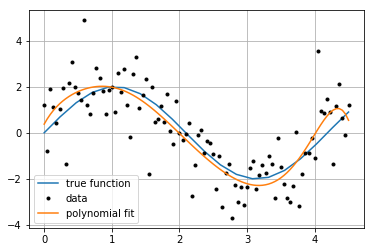

In [19]:
model = PolynomialLinearRegression(degree=8)
model.fit(x,y)
p_y = model.predict(x)
pl.plot(f_x, f_y, label="true function")
pl.plot(x, y, 'k.', label="data")
pl.plot(x, p_y, label="polynomial fit")
pl.legend();
pl.grid();

Model averaging
---------------

The following code generates a set of samples of the same size and fits a poynomial to each sample. Then the average model is calculated. All the models, including the average model, are plotted.

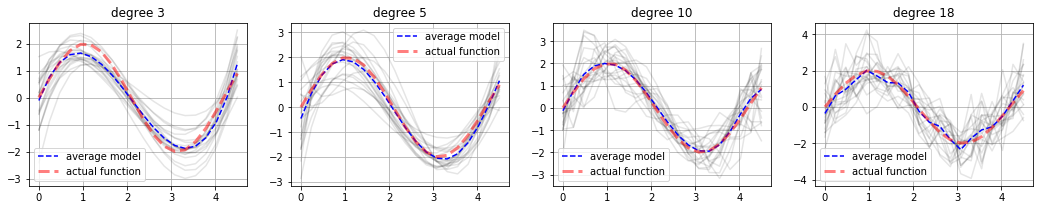

In [30]:
pl.figure(figsize=(18,3))
for k, degree in enumerate([3, 5, 10, 18]):
    pl.subplot(1,4,k+1)
    n_samples = 20
    n_models = 20
    avg_y = np.zeros(n_samples)
    for i in range(n_models):
        (x,y) = sample(n_samples)
        model = PolynomialLinearRegression(degree=degree)
        model.fit(x,y)
        p_y = model.predict(x)
        avg_y = avg_y + p_y
        pl.plot(x, p_y, 'k-', alpha=.1)
    avg_y = avg_y / n_models
    pl.plot(x, avg_y, 'b--', label="average model")
    pl.plot(x, f(len(x))[1], 'b--', color="red", lw="3", alpha=.5, label="actual function")
    pl.legend();
    pl.grid();
    pl.title("degree %d"%degree)

Calculating bias and variance
-----------------------------

Same as previous example, we generate several samples and fit a polynomial to each one. We calculate bias an variance among models for different polynomial degrees. Bias, variance and error are plotted against different degree values.

We have 

- $m$ models and $n$ data points
- $\hat{y}^{(i)}_k$ the prediction of model $k$ on data point $i$ 

- $\hat{y}^{(i)} = \frac{1}{m}\sum_{k=1..m}\hat{y}^{(i)}_k$ the average prediction of over all models on data point $i$ 

**Bias** is defined as the average error of the average prediction

$$\frac{1}{n}\sum_{i=1..n}(\hat{y}^{(i)}-y^{(i)})^2$$

**Variance** is defined as the variability of model predictions with respect to the average prediction

$$\frac{1}{nm}\sum_{i=1..n}\sum_{k=1..m}(\hat{y}^{(i)}_k -\hat{y}^{(i)})^2$$

And it is know that the overall prediction error can be decomposed:

$$\text{Error} = \text{Bias} + \text{Variance}$$

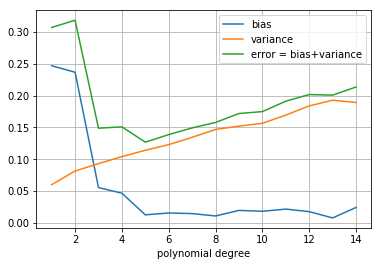

In [31]:
from numpy.linalg import norm
n_samples = 20
f_x, f_y = f(n_samples)
n_models = 100
max_degree = 15
var_vals =[]
bias_vals = []
error_vals = []
for degree in range(1, max_degree):
    avg_y = np.zeros(n_samples)
    models = []
    for i in range(n_models):
        (x,y) = sample(n_samples)
        model = PolynomialLinearRegression(degree=degree)
        model.fit(x,y)
        p_y = model.predict(x)
        avg_y = avg_y + p_y
        models.append(p_y)
    avg_y = avg_y / n_models
    bias_2 = norm(avg_y - f_y)/f_y.size
    bias_vals.append(bias_2)
    variance = 0
    for p_y in models:
        variance += norm(avg_y - p_y)
    variance /= f_y.size * n_models
    var_vals.append(variance)
    error_vals.append(variance + bias_2)
pl.plot(range(1, max_degree), bias_vals, label='bias')
pl.plot(range(1, max_degree), var_vals, label='variance')
pl.plot(range(1, max_degree), error_vals, label='error = bias+variance')
pl.legend()
pl.xlabel("polynomial degree")
pl.grid();

observe the variability of the models of different degrees (complexity) with different data samples

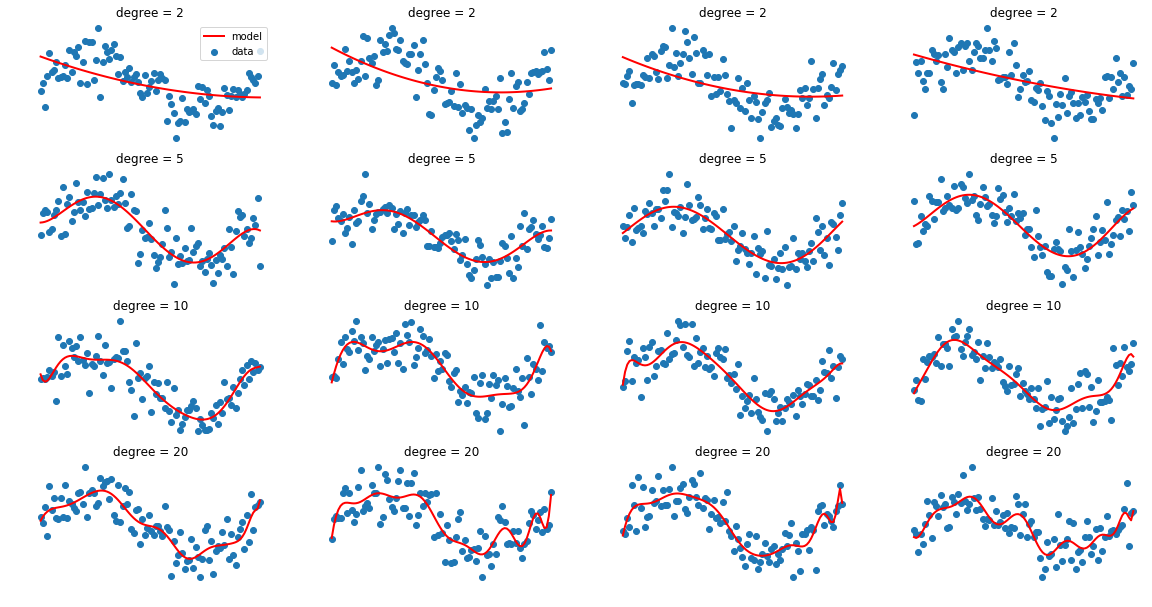

In [32]:
pl.figure(figsize=(20,13))
i = 1
n_samples=100
for d in [2,5,10,20]:
    for _ in range(4):
        pl.subplot(5,4,i)
        (x,y) = sample(n_samples)
        model = PolynomialLinearRegression(degree=d)
        model.fit(x,y)
        yp = model.predict(x)        
        pl.scatter(x,y, label="data")
        pl.plot(x,yp, color="red", lw=2, label="model")
        if i==1:
            pl.legend();
        pl.title("degree = %d"%d)
        i+=1
        pl.axis("off")
        